In [1]:
import numpy
import bempp.api
from bempp.api.operators.boundary import sparse, laplace
from scipy.sparse.linalg import gmres

In [2]:
def generate_grid(filename):
    
    face = open(filename+'.face','r').read()
    vert = open(filename+'.vert','r').read()

    faces = numpy.vstack(numpy.char.split(face.split('\n')[0:-1]))[:,:3].astype(int) - 1
    verts = numpy.vstack(numpy.char.split(vert.split('\n')[0:-1]))[:,:3].astype(float)

    grid = bempp.api.grid_from_element_data(verts.transpose(), faces.transpose())
    
    N = grid.leaf_view.entity_count(0)
    elements = list(grid.leaf_view.entity_iterator(0))
    area = numpy.zeros(N)

    # remove zero areas
    for i in range(N):
        area[i] = elements[i].geometry.volume

    area_nonzero = numpy.where(area>1e-12)[0]
    
    faces_nonzero = faces[area_nonzero,:]
    
    grid = bempp.api.grid_from_element_data(verts.transpose(), faces_nonzero.transpose())
    
    return grid

In [3]:
def vdw_energy_mol(atom_xyzr, atom_vdw, mesh):

    qe = 1.60217662e-19
    Na = 6.0221409e23
    rho_w = 0.0336# 1/angs3 number density of water at standard conditions
    water_r = 1.7683 # angs
    water_eps = 0.1520 # kcal/mol
    
    atom_pos = atom_xyzr[:,:3]
    atom_r   = atom_xyzr[:,3]
    N_atom = len(atom_r)
    atom_eps = numpy.zeros(N_atom)

    i=0
    for line in file(atom_vdw):
        line = line.split()
        atom_eps[i] = float(line[-1])
        i += 1

    grid = generate_grid(mesh)

    N_panel = grid.leaf_view.entity_count(0)
    vertices = grid.leaf_view.vertices 
    triangles = grid.leaf_view.elements
    elements = list(grid.leaf_view.entity_iterator(0))

    area = numpy.zeros(N_panel)
    center = numpy.zeros((N_panel,3))
    normal = numpy.zeros((N_panel,3))
    for i in range(N_panel):
        area[i] = elements[i].geometry.volume
        center[i,:] = numpy.average(elements[i].geometry.corners[:],axis=1)
        v1 = elements[i].geometry.corners[:,1] - elements[i].geometry.corners[:,0]
        v2 = elements[i].geometry.corners[:,2] - elements[i].geometry.corners[:,0]
        normal[i,:] = numpy.cross(v1,v2)/(2*area[i]) 

    integral_i = numpy.zeros(N_atom)
    for i in range(N_atom):
        r_local = center - atom_pos[i,:]
        r_norm = numpy.sqrt(numpy.sum(r_local**2, axis=1))
        rdn = numpy.sum(r_local*normal, axis=1)
        epsilon = numpy.sqrt(water_eps*atom_eps[i])
    
        A = epsilon*(water_r + atom_r[i])**12
        B = 2*epsilon*(water_r + atom_r[i])**6
        
        r_large = numpy.where(r_norm>0.4*atom_r[i])[0]
        if len(r_large)!=len(r_norm):
            print 'Triangles out: %i'%(len(center)-len(r_large))
    
        integral_i[i] = numpy.sum((A/(9*r_norm[r_large]**12) - B/(3*r_norm[r_large]**6)) * rdn[r_large] * area[r_large])   

    energy = rho_w*numpy.sum(integral_i) #kcal/mol
    return energy


In [5]:
problem_folder = 'mobley_test/'
namefile = 'actually_all_names.txt'
num_lines = sum(1 for line in open(problem_folder+namefile))
energy = numpy.zeros(num_lines)
it = 0
for line in file(problem_folder+namefile):
    mol = line[:-1]

    mesh_stern = problem_folder+mol+'/surf_d20_stern28'
    mesh_diel = problem_folder+mol+'/surf_d20'
    atom_xyzr = numpy.loadtxt(problem_folder+mol+'/'+mol+'.xyzr')
    atom_vdw = problem_folder+mol+'/'+mol+'.vdw'

    
    try: 
        e = vdw_energy_mol(atom_xyzr, atom_vdw, mesh_stern)
    except:
        print 'Something went wrong'
        e = 0
    
    energy[it] = e
    
    print 'Run %i for '%it + mol + '. Energy = %1.3f kcal/mol'%energy[it]
    
    it += 1
    
numpy.savetxt('vdw_energy.txt', energy)

Run 0 for 1112_tetrachloroethane. Energy = -4.482 kcal/mol
Run 1 for 111_trichloroethane. Energy = -3.885 kcal/mol
Run 2 for 111_trifluoro_222_trimethoxyethane. Energy = -4.753 kcal/mol
Run 3 for 111_trifluoropropan_2_ol. Energy = -3.322 kcal/mol
Run 4 for 111_trimethoxyethane. Energy = -4.414 kcal/mol
Run 5 for 1122_tetrachloroethane. Energy = -4.501 kcal/mol
Run 6 for 112_trichloro_122_trifluoroethane. Energy = -4.261 kcal/mol
Run 7 for 112_trichloroethane. Energy = -3.919 kcal/mol
Run 8 for 11_diacetoxyethane. Energy = -4.955 kcal/mol
Run 9 for 11_dichloroethane. Energy = -3.301 kcal/mol
Run 10 for 11_dichloroethene. Energy = -3.127 kcal/mol
Run 11 for 11_diethoxyethane. Energy = -4.539 kcal/mol
Run 12 for 11_difluoroethane. Energy = -2.251 kcal/mol
Run 13 for 1234_tetrachlorobenzene. Energy = -5.765 kcal/mol
Run 14 for 1235_tetrachlorobenzene. Energy = -5.806 kcal/mol
Run 15 for 123_trichlorobenzene. Energy = -5.187 kcal/mol
Run 16 for 123_trimethylbenzene. Energy = -4.708 kcal/mol

Run 147 for 35_dimethylphenol. Energy = -4.674 kcal/mol
Run 148 for 35_dimethylpyridine. Energy = -4.362 kcal/mol
Run 149 for 3_acetylpyridine. Energy = -4.678 kcal/mol
Run 150 for 3_chloroaniline. Energy = -4.453 kcal/mol
Run 151 for 3_chlorophenol. Energy = -4.423 kcal/mol
Run 152 for 3_chloroprop_1_ene. Energy = -2.963 kcal/mol
Run 153 for 3_chloropyridine. Energy = -4.101 kcal/mol
Run 154 for 3_cyanophenol. Energy = -4.797 kcal/mol
Run 155 for 3_cyanopyridine. Energy = -4.481 kcal/mol
Run 156 for 3_ethylphenol. Energy = -4.644 kcal/mol
Run 157 for 3_ethylpyridine. Energy = -4.336 kcal/mol
Run 158 for 3_formylpyridine. Energy = -4.240 kcal/mol
Run 159 for 3_hydroxybenzaldehyde. Energy = -4.563 kcal/mol
Run 160 for 3_methoxyaniline. Energy = -4.682 kcal/mol
Run 161 for 3_methoxyphenol. Energy = -4.653 kcal/mol
Run 162 for 3_methyl_1h_indole. Energy = -4.933 kcal/mol
Run 163 for 3_methyl_but_1_ene. Energy = -3.250 kcal/mol
Run 164 for 3_methylbut_1_ene. Energy = -3.250 kcal/mol
Run 16

Run 298 for dimethyl_disulfide. Energy = -3.452 kcal/mol
Run 299 for dimethyl_ether. Energy = -2.352 kcal/mol
Run 300 for dimethyl_sulfate. Energy = -4.249 kcal/mol
Run 301 for dimethyl_sulfide. Energy = -2.717 kcal/mol
Run 302 for dimethyl_sulfone. Energy = -3.548 kcal/mol
Run 303 for dimethyl_sulfoxide. Energy = -3.156 kcal/mol
Run 304 for dimethylamine. Energy = -2.472 kcal/mol
Run 305 for ethanamide. Energy = -2.745 kcal/mol
Run 306 for ethane. Energy = -1.917 kcal/mol
Run 307 for ethanethiol. Energy = -2.688 kcal/mol
Run 308 for ethanol. Energy = -2.377 kcal/mol
Run 309 for ethene. Energy = -1.642 kcal/mol
Run 310 for ethyl_acetate. Energy = -3.627 kcal/mol
Run 311 for ethyl_benzoate. Energy = -5.361 kcal/mol
Run 312 for ethyl_butanoate. Energy = -4.587 kcal/mol
Run 313 for ethyl_formate. Energy = -3.189 kcal/mol
Run 314 for ethyl_hexanoate. Energy = -5.568 kcal/mol
Run 315 for ethyl_pentanoate. Energy = -5.075 kcal/mol
Run 316 for ethyl_phenyl_ether. Energy = -4.644 kcal/mol
Run 

Run 453 for pentan_3_ol. Energy = -3.860 kcal/mol
Run 454 for pentan_3_one. Energy = -3.746 kcal/mol
Run 455 for pentanal. Energy = -3.804 kcal/mol
Run 456 for pentanenitrile. Energy = -4.078 kcal/mol
Run 457 for pentanoic_acid. Energy = -4.231 kcal/mol
Run 458 for phenanthrene. Energy = -6.155 kcal/mol
Run 459 for phenol. Energy = -3.771 kcal/mol
Run 460 for phenyl_formate. Energy = -4.391 kcal/mol
Run 461 for phenyl_methyl_sulfide. Energy = -4.471 kcal/mol
Run 462 for phenyl_trifluoroethyl_ether. Energy = -5.017 kcal/mol
Run 463 for piperazine. Energy = -4.194 kcal/mol
Run 464 for piperidine. Energy = -3.833 kcal/mol
Run 465 for prop_2_en_1_ol. Energy = -2.709 kcal/mol
Run 466 for propan_1_ol. Energy = -2.924 kcal/mol
Run 467 for propan_2_ol. Energy = -2.891 kcal/mol
Run 468 for propane. Energy = -2.485 kcal/mol
Run 469 for propanenitrile. Energy = -3.048 kcal/mol
Run 470 for propanoic_acid. Energy = -3.217 kcal/mol
Run 471 for propanone. Energy = -2.789 kcal/mol
Run 472 for propene.

In [7]:
#molecule = 'nitroethane'
#mesh_stern = 'mobley_test/'+molecule+'/surf_d02_stern'
#mesh_diel = 'mobley_test/'+molecule+'/surf_d02'
#atom_vdw = 'mobley_test/'+molecule+'/'+molecule+'.vdw'
#atom_xyzr = numpy.loadtxt('mobley_test/'+molecule+'/'+molecule+'.xyzr')
mesh_stern = 'sphere_test/sphere2K_R10'
atom_vdw = 'sphere_test/sphere_atoms.vdw'
atom_xyzr = numpy.loadtxt('sphere_test/sphere_atoms.xyzr')

energy = vdw_energy_mol(atom_xyzr, atom_vdw, mesh_stern)
print energy

-2314.95282858


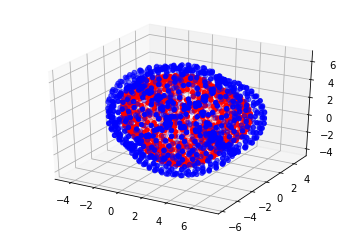

In [13]:
# test if normals are pointing out
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot

grid = generate_grid(mesh_stern)

N_panel = grid.leaf_view.entity_count(0)
vertices = grid.leaf_view.vertices 
triangles = grid.leaf_view.elements
elements = list(grid.leaf_view.entity_iterator(0))

area = numpy.zeros(N_panel)
center = numpy.zeros((N_panel,3))
normal = numpy.zeros((N_panel,3))
for i in range(N_panel):
    area[i] = elements[i].geometry.volume
    center[i,:] = numpy.average(elements[i].geometry.corners[:],axis=1)
    v1 = elements[i].geometry.corners[:,1] - elements[i].geometry.corners[:,0]
    v2 = elements[i].geometry.corners[:,2] - elements[i].geometry.corners[:,0]
    normal[i,:] = numpy.cross(v1,v2)/(2*area[i]) 
    
fig = pyplot.figure()
ax = fig.add_subplot(111,projection='3d')
cpn = center+normal

ax.scatter(center[:,0],center[:,1],center[:,2],c='r')
ax.scatter(cpn[:,0], cpn[:,1], cpn[:,2],c='b')
pyplot.show()